In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from scipy import stats
import json 
import yaml
import os 
import copy
from PIL import Image, ImageEnhance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from adjustText import adjust_text

## Parameters

In [4]:
# set a few parameters 
working_dir = os.getcwd()
data_dir = working_dir + "/../data/animals_vehicles_0_ratings/"
image_dir = working_dir + "/../assets/stimuli/animals_vehicles/"
num_trials = 250
num_subs = 30 # per group
num_animals = 250
num_objects = 250
n_size = 5
n_speed = 5 


## Scratchpad

In [80]:
# yolo

## Functions

In [5]:
def set_names():
    '''
    assign labels to each combination of size and speed.

    '''
    size,speed = np.meshgrid(np.arange(0,5),np.arange(0,5))
    features = np.asarray((size.ravel(),speed.ravel())).T+1
    vehicles = np.array(['inflatable-boat','gondola','tractor','hot-air-balloon','cargo-ship','bicycle','covered-wagon','bulldozer','sailboat','cruise-ship','scooter','slow-car','bus','cargo-truck','naval-ship','snowmobile','sports-car','helicopter','fire-truck','passenger-plane','sports-motorbike','military-drone','speed-boat','fighter-jet','rocket'])

    animals = np.array(['snail','mole','seal','orangutan','walrus','caterpillar','hamster','pig','cow','elephant','bumblebee','squirrel','sheep','dolphin','rhinoceros','butterfly','rabbit','wolf','lion','giraffe','horsefly','bat','leopard','horse','orca'])

    mat = np.stack([features[:,0],features[:,1],vehicles,animals],axis=1)
    labels = pd.DataFrame(mat,columns=['size','speed','vehicle','animal'])
    labels['size'] = labels['size'].astype('int')
    labels['speed'] = labels['speed'].astype('int')
    return labels

def get_features(img_name):
    '''
    extracts stimulus features (size, speed etc) from its file name
    '''
    img_split = img_name.split('_')
    domain = img_split[0]
    size = img_split[1][-1]
    speed = img_split[2][-1]
    exemplar = img_split[-1][0]
    return domain,size,speed,exemplar 

def get_data(data_dir):
    '''
    parser to import single subject data from .txt files (json format)
    '''
    alldata = {'speed_gt':[],'size_gt':[],'domain':[],'feature':[],'ratings':[],'exemplars':[]}
    # load data from singel subject 
    files = os.listdir(data_dir)
    for subfile in files:
        with open(data_dir + subfile,'r') as f:
            data = yaml.load(f,Loader=yaml.FullLoader)
        alldata['domain'].append(data['stim_domain'])
        alldata['feature'].append(data['stim_feature'])
        ims = data['images']
        alldata['ratings'].append(data['responses'])
        speed_gt = np.empty((len(ims)))
        size_gt = np.empty((len(ims)))
        exemplar_id = np.empty((len(ims)))
        for ii,img in enumerate(ims):      
            _,size_gt[ii],speed_gt[ii],exemplar_id[ii] = get_features(img)
        alldata['speed_gt'].append(speed_gt)
        alldata['size_gt'].append(size_gt)
        alldata['exemplars'].append(exemplar_id)

    # convert to numpy arrays 
    for k in alldata.keys():
        alldata[k] = np.asarray(alldata[k])        
    return alldata



def average_data(alldata,method='mode'):
    '''
    averages data across participants with chosen method
    creates five unique bins (from very low to very high)
    returns dataframe with separate columns for each feature

    inputs:
    - alldata: dataset as generated by gen_data()
    - method: averaging technique (mode,mean,median)
    '''
    pass


def hist_ratings(alldata,nbins=5):
    ''' plot distribution of mean ratings '''
    plt.figure(figsize=(10,10))
    # ax= sns.histplot(np.round(np.nanmean(alldata['ratings'],1),2),bins=nbins)
    ax= sns.histplot(stats.mode(alldata['ratings'],1)[0],bins=nbins,legend=False)
    sns.despine()
    ax.set(xlabel='rating',ylabel='number of stimuli',title='Avg Ratings (mode), ' + alldata['domain'] + ' - ' + alldata['feature'])


def hist_stddev(alldata,nbins=15):
    ''' plot distribution of rating consistency'''
    plt.figure(figsize=(10,10))
    ax= sns.histplot(np.round(np.nanstd(alldata['ratings'],1),2),bins=nbins)
    sns.despine()
    ax.set(xlabel='std',ylabel='number of stimuli',title='Rating variability, ' + alldata['domain'] + ' - ' + alldata['feature'])


def disp_4x5grid(image_ids,alldata,lvl='very low'):
    plt.figure(figsize=(12,7))
    plt.suptitle(alldata['domain'] + '-' + alldata['feature'] + ': ' + lvl)
    for ii,im in enumerate(image_ids):
        # load image 
        with Image.open(image_dir + alldata['domain'] + str(im) + '.png') as im:
            img = np.asarray(im)
        plt.subplot(4,5,ii+1)
        plt.imshow(img)
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')


def disp_samples_perbin(data,feature='dangerousness'):
    if feature=='dangerousness':
        levels = ['very low','low','medium','high','very high']
    elif feature=='size':
        levels = ['very small','small','medium','large','very large']
    elif feature=='speed':
        levels = ['very slow', 'slow','medium','fast','very fast']
    
    # take mode across participants 
    mean_ratings_all = stats.mode(data['ratings'],1)[0].ravel()
    # obtain bin ids 
    bin_idces = bin_data(mean_ratings_all)
    # loop over levels, create a single figure per level 
    for lvl in range(5):
        image_ids = data['image_ids'][bin_idces==lvl+1]
        # sample images (not more than I have in smallest bin)
        image_ids = np.random.choice(image_ids,np.bincount(bin_idces)[1:].min(),replace=False)
        disp_4x5grid(image_ids,data,lvl=levels[lvl])




def bin_data(data,nbins=5):
    ''' assigns bin indices to each element of the input array'''
    idces = np.zeros(len(data))
    # compute boudaries
    bounds = np.linspace(min(data),max(data),nbins+1)
    for ii in range(0,nbins):
        idces[(data>bounds[ii]) & (data <= bounds[ii+1])] = ii+1
    idces = idces.astype('int')
    idces[idces==0] = 1
    return idces
        



def whiteToAlpha(img):
	""" renders white background of image transparent
	 found under http://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent """
	img   = img.convert("RGBA")
	datas =       img.getdata()

	newData = []
	for item in datas:
		if item[0] > 250 and item[1] > 250 and item[2] > 250: # i.e. pixel is 'white' [changed, thresh was 100]
			newData.append((255,255,255,0)) # adds zero opacity
		else:
			newData.append(item)
	img.putdata(newData)
	return img

## Analysis Plan

### 1) Consistency with ground truth 
Each stimulus has a ground truth size and speed rating (assigned by experimenter). I want to know whether the ratings given by our participants are consistent with our gt ratings. 
Idea: Plot one against the other.  
Note that we have multiple ratings within participants (multiple exemplar images for each combination of size and speed). 
1st level: Take mode across exemplars within subjects 
2nd level: take mode across subjects 

### 2) Correlation between dimensions
We defined the features to be orthogonal: In the ground truth, there is zero correlation between size and speed. But what about the subject ratings? 
Idea: Plot one against the other, compute rank correlation (of modes)


## Import raw data

In [6]:
data = get_data(data_dir)

## Average within and across subjects 

In [7]:

def compute_rating_centraltendencies(data,domain='animal',feature='size',measure='mode'):
    '''
    for each stimulus, take mode/median/mean of ratings within subjects
    returns a subject-x-stimulus matrix of rating mats 
    '''
    # replace feature labels with those used in experiment
    if feature=='size':
        feature = 'large'
    elif feature=='speed':
        feature = 'fast'

    si,sp = np.meshgrid(np.arange(1,n_size+1),np.arange(1,n_speed+1))
    labels = set_names().to_numpy()

    # animals - size
    ratings = data['ratings'][(data['domain'] == domain) & (data['feature']==feature),:]
    speed = data['speed_gt'][(data['domain'] == domain) & (data['feature']==feature),:]
    size = data['size_gt'][(data['domain'] == domain) & (data['feature']==feature),:]
    mu = []
    for subj in range(ratings.shape[0]):    
        # loop over ground truth combinations of size and speed. For each, find exemplars and take mode 
        sub_mu = []
        for ii in range(labels.shape[0]):
            row = labels[ii,:]
            if measure=='mode':                
                sub_mu.append(stats.mode(ratings[subj,(speed[subj,:] == row[1]) & (size[subj,:]==row[0])])[0])
            elif measure=='median':
                sub_mu.append(np.median(ratings[subj,(speed[subj,:] == row[1]) & (size[subj,:]==row[0])]))
            elif measure=='mean':
                sub_mu.append(np.mean(ratings[subj,(speed[subj,:] == row[1]) & (size[subj,:]==row[0])]))
        # add subject ratings to list
        mu.append(sub_mu)
    # turn list of list into 2d array
    if measure=='mode':
        mu = np.asarray(mu)[:,:,0]
    else:
        mu = np.asarray(mu)
    return mu 

def disp_rating_mats(mats,domain,feature,ax):
    im = ax.imshow(mats)
    ax.set(title=''.join([domain, 's', ' - ', feature]),xlabel='image',ylabel='participant')
    # cb = plt.colorbar(ax=ax)
    # cb.set_ylabel('rating')
    cb = plt.colorbar(im,ax=ax)
    cb.set_label('rating')

NameError: name 'disp_rating_modes' is not defined

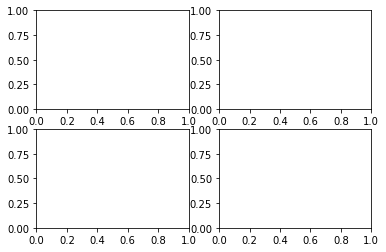

In [8]:
domains = ['animal','vehicle']
features = ['speed','size']
f,ax = plt.subplots(2,2)

for ii,dom in enumerate(domains):
    for jj,feat in enumerate(features):
        modes = compute_rating_centraltendencies(data,domain=dom,feature=feat,measure='median')
        disp_rating_modes(modes,dom,feat,ax[ii,jj])
plt.suptitle('        Consistency of Ratings',fontweight='bold')
plt.tight_layout()

## Coverage of 5x5 space

In [24]:
%matplotlib qt
def subplot_ratings(data,domain='animal',measure='median',labels=set_names().to_numpy()[:,-1],col='k'):
    if measure=='median':
        m1 = np.median(compute_rating_centraltendencies(data,domain,'size',measure='median'),0)
        m2 = np.median(compute_rating_centraltendencies(data,domain,'speed',measure='median'),0)
    elif measure=='mean':
        m1 = np.mean(compute_rating_centraltendencies(data,domain,'size',measure='mean'),0)
        m2 = np.mean(compute_rating_centraltendencies(data,domain,'speed',measure='mean'),0)
    elif measure=='mode':
        m1 = stats.mode(compute_rating_centraltendencies(data,domain,'size',measure='mode'))[0]
        m2 = stats.mode(compute_rating_centraltendencies(data,domain,'speed',measure='mode'))[0]

    plt.scatter(m1,m2,alpha=0.6,s=30,c=col)
    
    texts = [plt.text(m1[i], m2[i], labels[i], ha='center', va='center') for i in range(len(m1))]
    adjust_text(texts,arrowprops=dict(arrowstyle='-', color='k'))
    t,p = stats.kendalltau(m1,m2)
    plt.title(domain.capitalize() + 's \n'+  r'$\tau_{a}(size,speed)$' + ' = {:.2f}, p = {:.2f}'.format(t,p))
    plt.xlabel('size')
    plt.ylabel('speed')
    sns.despine()
    _ = plt.xticks(np.arange(1,6))
    _ = plt.yticks(np.arange(1,6))
    ax = plt.gca()
    ax.set_aspect('equal', 'box')

def plot_ratings(data,measure='median'):
    plt.figure(figsize=(12,7))
    plt.subplot(1,2,1)
    subplot_ratings(data,domain='animal',measure=measure,labels=set_names().to_numpy()[:,-1],col='green')
    plt.subplot(1,2,2)
    subplot_ratings(data,domain='vehicle',measure=measure,labels=set_names().to_numpy()[:,-2],col='red')

    plt.suptitle(measure.capitalize() + ' of ratings (across subjects)',fontweight='bold')
    plt.tight_layout()

%matplotlib qt
plot_ratings(data,measure='median')


## Consistency of subject's ratings with ground truth

In [25]:
# %matplotlib qt
labels = set_names().to_numpy()
def plot_rating_consistency(data):
    domains = ['animal','vehicle']
    features = ['size','speed']
    cols = ['green','red']
    markers = ['o','s']
    plt.figure(figsize=(12,12))
    idx = 1
    for d,domain in enumerate(domains):
        for f,feature in enumerate(features):
            plt.subplot(2,2,idx)
            idx += 1

            ratings = np.median(compute_rating_centraltendencies(data,domain,feature,measure='median'),0)
            plt.scatter(labels[:,f],ratings,alpha=0.5,s=100,marker=markers[f],c=cols[d])

            texts = [plt.text(labels[i,f], ratings[i], labels[i,-1*(d+1)], ha='center', va='center') for i in range(labels.shape[0])]
            adjust_text(texts,arrowprops=dict(arrowstyle='-', color='k'))
            plt.xlabel('ground truth')
            plt.ylabel('participant average')
            _ = plt.xticks(np.arange(1,6))
            _ = plt.yticks(np.arange(1,6))
            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            t,p = stats.kendalltau(labels[:,f],ratings)
            if p< 0.001:
                plt.title(domain.capitalize() + 's - ' + feature + ' \n'+  r'$\tau_{a}(labels, ratings)$' + ' = {:.2f}, p < 0.001'.format(t))
            else:
                plt.title(domain.capitalize() + 's - ' + feature + ' \n'+  r'$\tau_{a}(labels, ratings)$' + ' = {:.2f}, p = {:.3f}'.format(t, p))

            # plt.title(domain.capitalize() + 's - ' + feature,fontweight='bold')
            ax.set_aspect('equal', 'box')
    plt.tight_layout()
plot_rating_consistency(data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
